In [1]:
import copy
import csv
from enum import Enum
import io
import json
import os
import typing as t

import cv2
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
)
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

In [2]:
from utils import (
    show_photos, 
    create_dataloader,
    train_epoch,
    test_epoch,
    plot_history,
    print_model_params_required_grad,
    PUBLIC_DATA_FOLDER_PATH,
    PUBLIC_DATA_DESCRIPTION_PATH,
)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Description

Yandex GO is one of the top three ride-hailing services in the world. Our app facilitates over 4 billion trips per year across 32 countries. We are committed to the quality of our services, ensuring thorough checks of both drivers and their vehicles before they go online, based on dozens of criteria. Part of the vehicle inspection process is carried out remotely using photos of the vehicle, which allows us to either block or grant the driver access to orders. This tool ensures that cars do not go online if they are damaged or dirty.

Computer vision algorithms play a significant role in this remote quality control process. Machine learning models act as a filter that processes vehicle inspection requests, automatically approving a portion of requests that, according to the models, contain no violations, and sending suspicious cases for additional manual review.

### How does the photo inspection process work?
As part of vehicle photo inspections, drivers periodically receive a task to take photos of their car, so it can be checked for damage, compliance with service standards, branding presence, etc. Before these checks, we also need to ensure that drivers took the photos honestly and sent what we expected. The driver is required to take 4 photos (front, rear, left side, right side). The photos are taken through the Yandex PRO app, which has an interface that guides them to capture the 4 photos in the correct order and from the required angles.

In the standard process, the photos are first reviewed by ML pipeline. If ML pipeline doesn't find anything suspicious in the photos, the inspection is automatically approved. If the pipeline flags at least one photo, the inspection is sent to an assessor for a final decision. Thus, the object for decision-making is the inspection itself, i.e., all 4 photos together.

In this task, the license plate numbers have been blacked out.

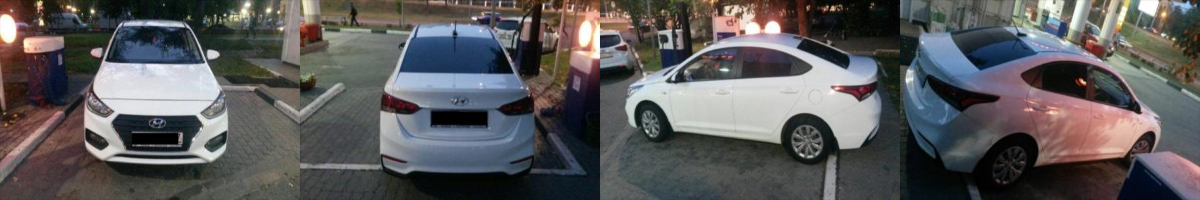

In [4]:
pass_id = '000f43a6549ad26d'
photos = []
for side in ['front', 'back', 'left', 'right']:
    with open(f'{PUBLIC_DATA_FOLDER_PATH}/{pass_id}_{side}', 'rb') as file:
        photos.append(file.read())
show_photos(photos)

### Data description: 
- **filename** —  name of the photo file, consisting of `pass_id` and `plan_side`.
- **pass_id** — ID of the inspection. Each inspection contains 4 photos.
- **plan_side** — the side of the vehicle that should be in the photo. Possible values: front, back, left, right.
- **fact_side** — the side of the vehicle as determined by assessors. Possible values: front, back, left, right, unknown.
- **fraud_verdict** — the assessor's verdict on what is depicted in the photo. Possible values:
   - ALL_GOOD —  the photo clearly shows one side of the vehicle, which is fully visible and in focus.
   - LACK_OF_PHOTOS — the photo does not contain a vehicle at all.
   - BLURRY_PHOTO — the photo is blurry.
   - SCREEN_PHOTO — not a real vehicle photo, but a photo of a screen.
   - DARK_PHOTO — the photo is too dark.
   - INCOMPLETE_CAPTURE — the vehicle is not fully visible in the photo.
- **fraud_probability** — the proportion of assessors who assigned the given fraud_verdict. If no verdict achieved a majority, a random one is chosen.
- **damage_verdict** — the assessor's verdict on the vehicle's condition. Possible values:
   - NO_DEFECT —  no visible damage.
   - DEFECT — the is some damage.
   - BAD_PHOTO — can't say anything about the damage, because of photo's quality.
- **damage_probability** — the proportion of assessors who assigned the given damage_verdict. If no verdict achieved a majority, a random one is chosen.

In [5]:
description = pd.read_csv(PUBLIC_DATA_DESCRIPTION_PATH, index_col='filename').sort_index()
description.head()

,pass_id,plan_side,fact_side,fraud_verdict,fraud_probability,damage_verdict,damage_probability
filename,,,,,,,
00015b960a1c013e_back,00015b960a1c013e,back,back,DARK_PHOTO,1.000000,BAD_PHOTO,0.8
00015b960a1c013e_front,00015b960a1c013e,front,front,DARK_PHOTO,0.666667,BAD_PHOTO,1.0
00015b960a1c013e_left,00015b960a1c013e,left,unknown,DARK_PHOTO,0.666667,BAD_PHOTO,0.6
00015b960a1c013e_right,00015b960a1c013e,right,unknown,DARK_PHOTO,0.666667,BAD_PHOTO,1.0
0001f673ef360c58_back,0001f673ef360c58,back,back,ALL_GOOD,0.666667,NO_DEFECT,1.0


In addition to fraud that can be identified by looking at an individual photo, there may be cases where each photo individually has a fraud_verdict of 'ALL_GOOD', but the driver took two photos of the same side of the vehicle and failed to capture another side:

In [6]:
description[description.pass_id == '001c07aa1e3edf7e']

,pass_id,plan_side,fact_side,fraud_verdict,fraud_probability,damage_verdict,damage_probability
filename,,,,,,,
001c07aa1e3edf7e_back,001c07aa1e3edf7e,back,back,ALL_GOOD,1.0,NO_DEFECT,1.0
001c07aa1e3edf7e_front,001c07aa1e3edf7e,front,front,ALL_GOOD,1.0,NO_DEFECT,1.0
001c07aa1e3edf7e_left,001c07aa1e3edf7e,left,front,ALL_GOOD,1.0,NO_DEFECT,1.0
001c07aa1e3edf7e_right,001c07aa1e3edf7e,right,back,ALL_GOOD,1.0,NO_DEFECT,0.8


# Objective
To assess the quality of vehicles and photos using machine learning algorithms:  
1. For detecting fraud (incorrect photos, unclear images, or incorrect photo sets).  
2. For detecting vehicle damage.

## Performance Metric and Deliverables
There are 2 targets and 4 sides of a vehicle in each exam. But after all, we need to predict whether the inspection should be sent to a human for review to provide feedback to the driver, or if there are no defects and the inspection can be automatically approved. This means that the metric is calculated not for individual photos for each target, but for the inspection as a whole.

*Evaluation Metric:* ROC AUC (object — inspection)

*Required Deliverables*:
- Model Weights: The trained model's weights for reproducibility and further analysis.
- Executable Script: A script containing all necessary code to run the model, including data reading, preprocessing steps, model architecture, inference code.
   

# Example

Let's try to train a fraud detection model with a simplified target that does not account for cases where two photos in an inspection may capture the same side of the vehicle. For this, we will use a pretrained ResNet18 model and replace its classifier.

In [7]:
class CarSide(Enum):
    FRONT = 0
    BACK = 1
    LEFT = 2
    RIGHT = 3
    UNKNOWN = 5
    
class FraudResolution(Enum):
    ALL_GOOD = 0
    LACK_OF_PHOTOS = 1
    BLURRY_PHOTO = 2
    SCREEN_PHOTO = 3
    DARK_PHOTO = 4
    INCOMPLETE_CAPTURE = 5
    RUDE_CONTENT = 6
    
class DamageResolution(Enum):
    NO_DEFECT = 0
    DEFECT = 1
    BAD_PHOTO = 2

In [8]:
IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGENET_RGB_STD = [0.229, 0.224, 0.225]
RESIZE_SIZE = (224, 224)


def pil_open(image_data: bytes) -> Image:
    return Image.open(io.BytesIO(image_data))


def preprocess(image_data: t.Optional[bytes]) -> torch.Tensor:
    return transforms.Compose([
        transforms.Lambda(pil_open),
        transforms.ToTensor(),
        transforms.Resize(RESIZE_SIZE),
        transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_STD),
    ])(image_data)

In [9]:
def get_damage_target(damage_resolution, *args):
    return int(damage_resolution != DamageResolution.NO_DEFECT.name)

In [10]:
damage_target = description.damage_verdict.apply(lambda x: get_damage_target(x))

In [11]:
BATCH_SIZE = 64
TRAIN_FRACTION = 0.7

total_size = damage_target.shape[0]
train_size = int(total_size * TRAIN_FRACTION)


train_loader = create_dataloader(
    img_dir_path=PUBLIC_DATA_FOLDER_PATH,
    target_map=damage_target[:train_size].to_dict(),
    description=description,
    batch_size=BATCH_SIZE,
    preprocessor=preprocess,
    num_load_workers=0,
)

test_loader = create_dataloader(
    img_dir_path=PUBLIC_DATA_FOLDER_PATH,
    target_map=damage_target[train_size:total_size].to_dict(),
    description=description,
    batch_size=BATCH_SIZE,
    preprocessor=preprocess,
    num_load_workers=0,
)

In [12]:
def train_model(
    model, 
    device, 
    train_loader, 
    test_loader, 
    epochs, 
    criterion, 
    optimizer, 
    scheduler=None, 
    save_best_model=True
):
    best_test_loss = None
    best_state_dict = None
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []
    
    model = model.to(device)
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}')
        train_loss, train_acc = train_epoch(
            model, 
            device,
            train_loader, 
            criterion, 
            optimizer
        )
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        
        if scheduler is not None:
            scheduler.step()
        
        test_loss, test_acc = test_epoch(model, device, test_loader, criterion)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)
        
        if best_test_loss is None or test_loss < best_test_loss:
            best_test_loss = test_loss
            best_state_dict = copy.deepcopy(model.state_dict())
        
        clear_output()
        plot_history(
            train_loss_history, 
            test_loss_history, 
            train_acc_history, 
            test_acc_history
        )
    
    if save_best_model:
        model.load_state_dict(best_state_dict)
    
    return {
        'train_loss': train_loss_history, 
        'test_loss': test_loss_history,
        'train_acc': train_acc_history,
        'test_acc': test_acc_history
    }

### ResNet18 baseline

In [13]:
# load pretrained model
model = resnet18(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

# replace classifier
model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
    torch.nn.Sigmoid(),
)

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def BCELoss_class_weighted(weights):
    
    def loss(pred, target):
        pred = torch.clamp(pred, min=1e-7, max=1-1e-7)
        bce = -weights[1] * target * torch.log(pred) - (1 - target) * weights[0] * torch.log(1 - pred)
        return torch.sum(bce)

    return loss

criterion = BCELoss_class_weighted(weights=[0.5, 0.5])

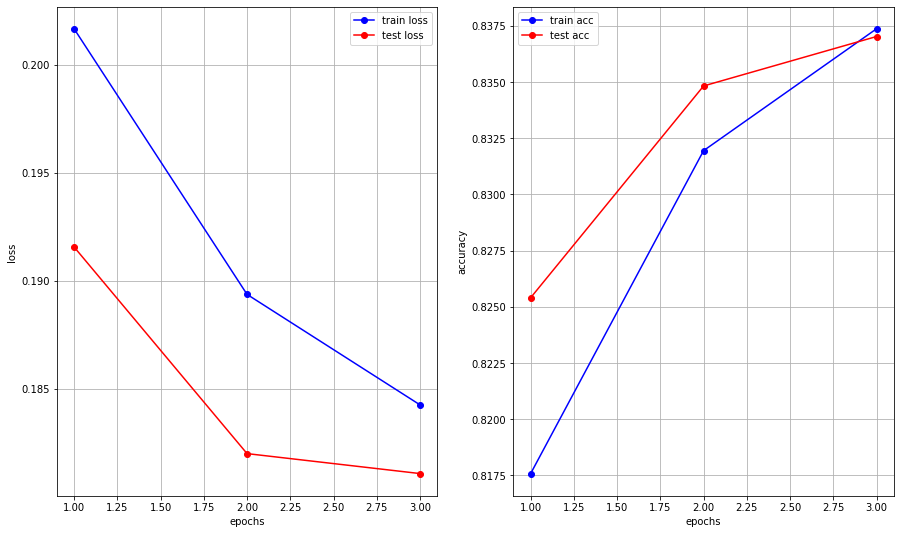

In [26]:
print_model_params_required_grad(model)

resnet_simple_fraud_log = train_model(
    model=model, 
    device=device,
    train_loader=train_loader, 
    test_loader=test_loader, 
    epochs=3, 
    criterion=criterion, 
    optimizer=optimizer, 
)

In [27]:
torch.save(model, 'baseline_damage.pt')

### Metric calculation

**NB**: There are only **filename**, **pass_id**, **plan_side** in private data description

In [15]:
from sklearn.metrics import roc_auc_score

from utils import get_predictions

In [16]:
model = torch.load('baseline_damage.pt')

In [17]:
test_predictions = get_predictions(model, device, test_loader)

  0%|          | 0/853 [00:00<?, ?it/s]

In [18]:
test_predictions.head()

,pass_id,pred,plan_side
0,a1240a46c165f6ca,0.999960,back
1,a1240a46c165f6ca,0.999920,front
2,a1240a46c165f6ca,0.999900,left
3,a1240a46c165f6ca,0.999946,right
4,a1252381f49a5101,0.011900,back


In [26]:
def make_complex_target(row):
    real = int(
        row.plan_side != row.fact_side or 
        row.fraud_verdict != 'ALL_GOOD' or
        row.damage_verdict != 'NO_DEFECT'
    )
    return pd.Series(
        data=[row.pass_id, real, row.pred],
        index=['pass_id', 'real', 'pred'],
    )

# All predictions for each vehicle are aggregated into a single value, 
# and the metric is calculated based on the inspections.
test_verdicts = test_predictions.merge(
    description, 
    on=['pass_id', 'plan_side']
).apply(make_complex_target, axis=1).groupby('pass_id').max()

test_verdicts.head()

,real,pred
pass_id,,
a1240a46c165f6ca,1,0.999960
a1252381f49a5101,1,0.284632
a1256f6b65a2193b,1,0.780581
a12659d9dceef2aa,1,0.514683
a1289c09d5a573cc,1,0.900998


In [27]:
score = roc_auc_score(test_verdicts.real, test_verdicts.pred)
print(f'simple fraud target roc_auc_score: {score}')

simple fraud target roc_auc_score: 0.9085364038531849


### Make a submission file

In [28]:
solution_script = '''
import typing as t
import io

import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms

from utils import (
    get_predictions, 
    create_dataloader,
    PRIVATE_DATA_FOLDER_PATH, 
    PRIVATE_DATA_DESCRIPTION_PATH,
)

BATCH_SIZE = 64
IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGENET_RGB_STD = [0.229, 0.224, 0.225]
RESIZE_SIZE = (224, 224)


def pil_open(image_data: bytes) -> Image:
    return Image.open(io.BytesIO(image_data))


def preprocess(image_data: t.Optional[bytes]) -> torch.Tensor:
    return transforms.Compose([
        transforms.Lambda(pil_open),
        transforms.ToTensor(),
        transforms.Resize(RESIZE_SIZE),
        transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_STD),
    ])(image_data)

device = torch.device('cpu')
model = torch.load('baseline_damage.pt', map_location=device)

description = pd.read_csv(PRIVATE_DATA_DESCRIPTION_PATH, index_col='filename').sort_index()
# there is no real target in private data description
dummy_target = {key: 0 for key in description.index}

val_loader = create_dataloader(
    img_dir_path=PRIVATE_DATA_FOLDER_PATH,
    target_map=dummy_target,
    description=description,
    batch_size=BATCH_SIZE,
    preprocessor=preprocess,
    num_load_workers=0,
)

solution = get_predictions(model, device, val_loader)
solution = solution[['pass_id', 'pred']].groupby('pass_id').max()
solution.to_csv('./solution.csv', index=False)
'''

In [29]:
exec(solution_script)

  0%|          | 0/313 [00:00<?, ?it/s]

In [34]:
# build the .zip to submit
import zipfile
import datetime

def make_zip_submission(model_path, solution_script):

    with open('run.py', 'w') as f_run:
        f_run.write(solution_script)

    with open('run.sh', 'w') as f_run_sh:
        f_run_sh.write('export PATH=/usr/conda/bin:$PATH\npython run.py')

    with open('train.py', 'w') as f_run:
        f_run.write('print("\\n".join(map(str, range(100))))')

    with open('train.sh', 'w') as f_run_sh:
        f_run_sh.write('export PATH=/usr/conda/bin:$PATH\npython train.py')

    with open('Makefile', 'w') as f_makefile:
        f_makefile.write('''all: build

    build:
        @echo 'starting....'
        bash train.sh
    run:
        bash run.sh
    train:
        bash train.sh
    ''')

    submission_zip = zipfile.ZipFile(
        f"submission-{datetime.datetime.now()}.zip".replace(':', '-').replace(' ', '-'),
        "w"
    )
    submission_zip.write('./Makefile', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('run.py', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('run.sh', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('train.py', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('train.sh', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('baseline_damage.pt', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('__init__.py', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('utils.py', compress_type=zipfile.ZIP_DEFLATED)

    submission_zip.close()

In [35]:
make_zip_submission(solution_script=solution_script)